<a href="https://colab.research.google.com/github/vtecftwy/metagenomics/blob/refactor_cnn_virus/2_01_test_cnn_virus_code_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test CNN_Virus code and refactor

Original code is [here](https://github.com/MaHaoran627/CNN_Virus)

In [1]:
import numpy as np
import os
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
COLAB = True

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
if COLAB:
    if not Path('repo').is_dir():
        !git clone -b refactor_cnn_virus https://github.com/vtecftwy/metagenomics.git repo

    cnn_src = Path('/content/repo/src')
    assert cnn_src.is_dir()

    data = Path('/content/gdrive/MyDrive/Metagen/CNN_Virus')
    assert data.is_dir()

    if cnn_src.is_dir():
        sys.path.insert(1, str(cnn_src))
        print(f"Added following path: {cnn_src}")
    else:
        print(f"There is no directory {cnn_src}")

# else:

#     cnn_repo = Path('../repos/cnn_virus/').resolve()
#     assert cnn_repo.is_dir()

#     data = Path('../data/cnn_virus').resolve()
#     assert data.is_dir()

#     p = Path('../src').resolve().absolute()
#     if p.is_dir():
#         sys.path.insert(1, str(p))
#         print(f"Added following path: {p}")
#     else:
#         print(f"There is no directory {p}")


Cloning into 'repo'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 108 (delta 51), reused 100 (delta 45), pack-reused 0
Receiving objects: 100% (108/108), 11.98 MiB | 6.01 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Added following path: /content/repo/src


# Preprocessing data

In [5]:
from preprocessing import get_learning_weights, get_params_50mer, get_kmer_from_50mer
from preprocessing import DataGenerator_from_50mer

from architecture import build_model

In [6]:
p2training = data / '50mer_training'
f_matrix, f_labels, f_pos = get_kmer_from_50mer(p2training, max_seqs=1_000_000)
len(f_matrix), len(f_labels), len(f_pos)

(1000000, 1000000, 1000000)

In [7]:
i = 0
f_matrix[i], f_labels[i], f_pos[i]

('TCAAAATAATCAGAAATGTTGAACCTAGGGTTGGACACATAATGACCAGC', '76', '0')

In [8]:
#path for the training file
filepath_train= data /"50mer_training"
assert filepath_train.is_file()
#path for the validating file
filepath_val= data / "50mer_validating"
assert filepath_val.is_file()
#path for the learning weights file
filepath_weights=data / "weight_of_classes"
assert filepath_weights.is_file()

In [9]:
d_nucl={"A":0,"C":1,"G":2,"T":3,"N":4}
f_matrix,f_labels,f_pos=get_kmer_from_50mer(filepath_train, max_seqs=1_000_000)
f_matrix_val,f_labels_val,f_pos_val=get_kmer_from_50mer(filepath_val)

params = get_params_50mer()
d_weights=get_learning_weights(filepath_weights)

training_generator = DataGenerator_from_50mer(f_matrix, f_labels, f_pos, **params)
val_generator = DataGenerator_from_50mer(f_matrix_val, f_labels_val, f_pos_val, **params)

In [10]:
len(training_generator)

977

[`tf.keras.utils.Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

In [11]:
tg = training_generator.__getitem__(5)

In [12]:
len(tg), type(tg), type(tg[0]), type(tg[1])

(2, tuple, numpy.ndarray, dict)

In [13]:
inp, out_d = tg
out_d.keys()

dict_keys(['output1', 'output2'])

In [14]:
inp.shape, out_d['output1'].shape, out_d['output2'].shape

((1024, 50, 5), (1024, 187), (1024, 10))

In [15]:
inp[:2, :4, :]

array([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]]])

In [16]:
out1 = out_d['output1']
out2 = out_d['output2']

out1[:2, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Build model and review it

In [17]:
model=build_model()
model.summary()

Creating Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 512)     2048        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 25, 512)      0           ['batch_normal

In [18]:
model.compile(
	  optimizer='adam',
	  loss={'output1':'categorical_crossentropy','output2':'categorical_crossentropy'},
	  metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

result = model.fit(
    training_generator,
	epochs=2,
	verbose=1,
	# class_weight=d_weights,
	validation_data=val_generator,
	callbacks=[es]
	)


Epoch 1/2
977/977 [==============================] - 442s 434ms/step - loss: 6.0758 - output1_loss: 3.7474 - output2_loss: 2.3284 - output1_accuracy: 0.1540 - output2_accuracy: 0.1237 - val_loss: 5.8436 - val_output1_loss: 3.5413 - val_output2_loss: 2.3023 - val_output1_accuracy: 0.1745 - val_output2_accuracy: 0.1357
Epoch 2/2
977/977 [==============================] - 426s 436ms/step - loss: 5.7177 - output1_loss: 3.4338 - output2_loss: 2.2839 - output1_accuracy: 0.1897 - output2_accuracy: 0.1478 - val_loss: 5.5499 - val_output1_loss: 3.3196 - val_output2_loss: 2.2304 - val_output1_accuracy: 0.2043 - val_output2_accuracy: 0.1696


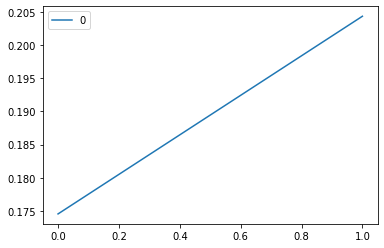

In [23]:
import pandas as pd
pd.DataFrame(result.history['val_output1_accuracy']).plot()

In [24]:
model.save(Path('saved_temp'))

In [27]:
from tensorflow.keras.models import load_model

m = load_model(Path('saved_temp'))

In [29]:
m.evaluate(val_generator)

977/977 [==============================] - 99s 101ms/step - loss: 5.5499 - output1_loss: 3.3196 - output2_loss: 2.2304 - output1_accuracy: 0.2043 - output2_accuracy: 0.1696


[5.549919128417969,
 3.319552421569824,
 2.2303643226623535,
 0.2043450027704239,
 0.16956399381160736]